In [52]:
#import all the packages
import sqlite3
import pandas as pd
from pandas_ml import ConfusionMatrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)






In [2]:
conn = sqlite3.connect('/Users/deeptisrini/Downloads/FPA_FOD_20170508.sqlite')



In [3]:
df = pd.read_sql(""" SELECT * from Fires""",con=conn)


In [49]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

# Data Pre-Processing 

## Feature Selection from the dataset

In [5]:
firedata = df.filter(['SOURCE_REPORTING_UNIT_NAME','STATE','LATITUDE','LONGITUDE','FIRE_SIZE_CLASS','FIRE_YEAR','DISCOVERY_DATE','STAT_CAUSE_DESCR','CONT_DATE'],axis=1)

firedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 9 columns):
SOURCE_REPORTING_UNIT_NAME    object
STATE                         object
LATITUDE                      float64
LONGITUDE                     float64
FIRE_SIZE_CLASS               object
FIRE_YEAR                     int64
DISCOVERY_DATE                float64
STAT_CAUSE_DESCR              object
CONT_DATE                     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 129.1+ MB


## Convert date from Julian to Gregorian calendar format 

In [6]:
firedata['DISCOVERY_DATE'] = pd.to_datetime(firedata['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
firedata['DAY_OF_WEEK'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.weekday_name
firedata['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
firedata['CONT_DATE'] = pd.to_datetime(firedata['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
firedata.head()

,SOURCE_REPORTING_UNIT_NAME,STATE,LATITUDE,LONGITUDE,FIRE_SIZE_CLASS,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,CONT_DATE,DAY_OF_WEEK,MONTH
0,Plumas National Forest,CA,40.036944,-121.005833,A,2005,2005-02-02,Miscellaneous,2005-02-02,Thursday,1
1,Eldorado National Forest,CA,38.933056,-120.404444,A,2004,2004-05-12,Lightning,2004-05-12,Thursday,1
2,Eldorado National Forest,CA,38.984167,-120.735556,A,2004,2004-05-31,Debris Burning,2004-05-31,Thursday,1
3,Eldorado National Forest,CA,38.559167,-119.913333,A,2004,2004-06-28,Lightning,2004-07-03,Thursday,1
4,Eldorado National Forest,CA,38.559167,-119.933056,A,2004,2004-06-28,Lightning,2004-07-03,Thursday,1


In [7]:
V = firedata['STATE'].value_counts()

States = V.index.tolist()

data = dict(type='choropleth',
            #colorscale = 'Viridis',
            colorscale = 'Reds',
            reversescale = False,
            locations = States,
            z = V,
            locationmode = 'USA-states',
            text = States,
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Fires by State"}
            )
layout = dict(title = 'Wilds Fires by States',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
#plot(choromap,validate=False)


In [8]:
iplot(choromap)

## Naive -bayes 

In [39]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
firedata['STAT_CAUSE_DESCR'] = enc.fit_transform(firedata['STAT_CAUSE_DESCR'])
firedata['DAY_OF_WEEK'] = enc.fit_transform(firedata['DAY_OF_WEEK'])
firedata['MONTH'] = enc.fit_transform(firedata['MONTH'])
firedata['FIRE_SIZE_CLASS'] = enc.fit_transform(firedata['FIRE_SIZE_CLASS'])
firedata['STATE'] = enc.fit_transform(firedata['STATE'])
X = firedata[['FIRE_YEAR','DAY_OF_WEEK','MONTH','STATE', 'LATITUDE','LONGITUDE','FIRE_SIZE_CLASS']]
y = firedata['STAT_CAUSE_DESCR']

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for Naive Baye's:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           0       0.34      0.11      0.17     56226
           1       0.00      0.00      0.00     15064
           2       0.00      0.00      0.00     12234
           3       0.33      0.78      0.47     85911
           4       0.00      0.00      0.00     29382
           5       0.00      0.00      0.00      2258
           6       0.33      0.64      0.44     55823
           7       0.31      0.20      0.24     64846
           8       0.89      0.19      0.31     33540
           9       0.00      0.00      0.00      2982
          10       0.00      0.00      0.00      6587
          11       0.00      0.00      0.00     10490
          12       0.00      0.00      0.00       750

   micro avg       0.34      0.34      0.34    376093
   macro avg       0.17      0.15      0.13    376093
weighted avg       0.31      0.34      0.27    376093

Score for Naive Baye's: 0.33994251421855765
Accuracy score: 0.34123740670525643

In [36]:
confusion_matrix = ConfusionMatrix(y_test, y_pred)
print("Confusion matrix:\n%s" % confusion_matrix)
 

Confusion matrix:
Predicted   0.0  1.0  2.0    3.0  4.0  5.0    6.0   7.0   8.0  9.0  10.0  \
Actual                                                                     
0.0         458    0    0   5011    0    0   2598   921   172    0     0   
1.0         277    0    0   3447    0    0   1792   665   104    0     0   
2.0         148    0    0   1534    0    0    794   318    46    0     0   
3.0         294    0    0   3315    0    0   1783   669    93    0     0   
4.0         179    0    0   2105    0    0   1056   459    62    0     0   
5.0          63    0    0    642    0    0    353   143    27    0     0   
6.0        1634    0    1  17307    0    0   9094  3522   579    0     0   
7.0         492    0    0   5459    0    0   2896  1158   176    0     0   
8.0          21    0    0    299    0    0    162    67     6    0     0   
9.0          24    0    0    253    0    0    119    54    11    0     0   
10.0         37    0    0    239    0    0    137    55    11    0    

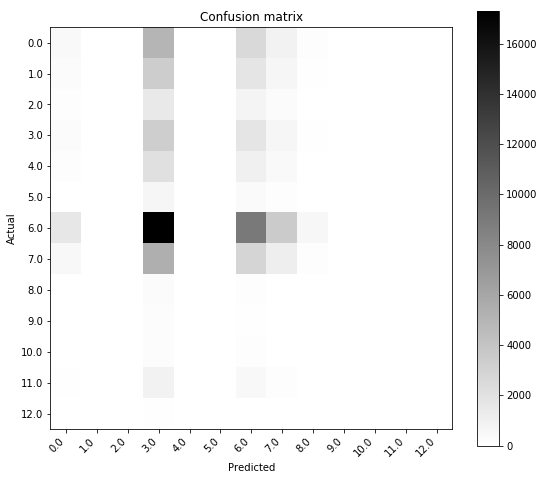

In [37]:
confusion_matrix.plot()

## Corelation Matrix for the Features 

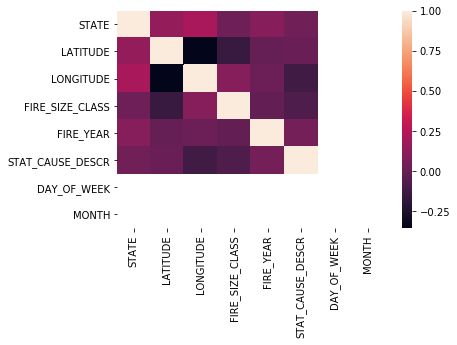

In [48]:
import seaborn as sns
corr =firedata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Decision Tree Classifier 

In [44]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)


from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  

print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.48      0.50      0.49     56226
           1       0.30      0.31      0.31     15064
           2       0.20      0.21      0.21     12234
           3       0.49      0.48      0.49     85911
           4       0.27      0.28      0.28     29382
           5       0.25      0.25      0.25      2258
           6       0.67      0.65      0.66     55823
           7       0.44      0.43      0.43     64846
           8       0.84      0.84      0.84     33540
           9       0.13      0.13      0.13      2982
          10       0.37      0.38      0.38      6587
          11       0.12      0.12      0.12     10490
          12       0.07      0.07      0.07       750

   micro avg       0.49      0.49      0.49    376093
   macro avg       0.36      0.36      0.36    376093
weighted avg       0.49      0.49      0.49    376093

Accuracy score: 0.48500503864735584


## Predict fire severity(fire class)

In [51]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
firedata['STAT_CAUSE_DESCR'] = enc.fit_transform(firedata['STAT_CAUSE_DESCR'])
firedata['DAY_OF_WEEK'] = enc.fit_transform(firedata['DAY_OF_WEEK'])
firedata['MONTH'] = enc.fit_transform(firedata['MONTH'])
firedata['FIRE_SIZE_CLASS'] = enc.fit_transform(firedata['FIRE_SIZE_CLASS'])
firedata['STATE'] = enc.fit_transform(firedata['STATE'])
X = firedata[['FIRE_YEAR','DAY_OF_WEEK','MONTH','STATE', 'LATITUDE','LONGITUDE','STAT_CAUSE_DESCR']]
y = firedata['FIRE_SIZE_CLASS']

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)



from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for Naive Baye's:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

print
y_test

Classification Report


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           0       0.56      0.48      0.51    133422
           1       0.57      0.79      0.66    187913
           2       0.00      0.00      0.00     43943
           3       0.00      0.00      0.00      5676
           4       0.00      0.00      0.00      2794
           5       0.00      0.00      0.00      1521
           6       0.07      0.20      0.10       824

   micro avg       0.56      0.56      0.56    376093
   macro avg       0.17      0.21      0.18    376093
weighted avg       0.48      0.56      0.51    376093

Score for Naive Baye's: 0.5617885735708987
Accuracy score: 0.5628607817747207


1362667    1
373919     1
484960     2
613044     1
439291     2
477050     2
1650630    0
414526     1
968309     1
1351053    1
332457     0
732196     0
1687586    0
775640     1
1473608    1
1615608    1
1837778    0
783596     1
1223853    1
1512564    0
1253719    0
1422563    1
126062     0
1492764    1
322052     0
792870     1
331457     1
1542900    1
1840021    0
1241178    1
          ..
169083     0
1589548    1
1395416    1
922031     1
1744096    1
1230904    0
864337     1
709144     2
720210     0
520438     1
548542     1
140219     1
1607057    0
899977     1
370898     2
859995     1
332875     0
124320     1
1614234    1
1334107    1
1784843    1
5275       1
995435     1
481281     1
1506162    2
1756520    1
887779     2
1197347    1
532971     1
1036399    0
Name: FIRE_SIZE_CLASS, Length: 376093, dtype: int64

In [46]:
confusion_matrix = ConfusionMatrix(y_test, y_pred)
print("Confusion matrix:\n%s" % confusion_matrix)
 

Confusion matrix:
Predicted    0.0    1.0  2.0  3.0  4.0  5.0  6.0  __all__
Actual                                                   
0.0        12252  27066    0    0    0    0  269    39587
1.0         7769  17986    0    0    0    0  149    25904
2.0         1848   4275    0    0    0    0   28     6151
3.0          430    960    0    0    0    0   11     1401
4.0          300    676    0    0    0    0    9      985
5.0          194    491    0    0    0    0    4      689
6.0          129    302    0    0    0    0    2      433
__all__    22922  51756    0    0    0    0  472    75150
